In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pickle
from multiprocessing import Pool
from tqdm import tqdm

# Prepare data

* Attributed rate: how attribution is distributed in combinations
* Click counts: how clicks are distributed in combinations
* Rolling click counts: how clicks are distributed in combinations in sliding windows

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
res_hdf_path = '../derived_data/feats_pile.hdf'

In [4]:
%%time
dat = pd.read_hdf(hdf_path, key='train')

CPU times: user 386 ms, sys: 7.47 s, total: 7.86 s
Wall time: 36.4 s


In [5]:
dat.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
train = dat.loc[(dat.click_time >= '2017-11-08 04:00:00') & (dat.click_time < '2017-11-08 15:00:00')].copy()

In [7]:
valid = dat.loc[(dat.click_time >= '2017-11-09 04:00:00') & (dat.click_time < '2017-11-09 15:00:00')].copy()

In [8]:
del dat

In [9]:
gc.collect()

24

In [10]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [11]:
feats2comb = ['ip', 'app', 'device', 'os', 'channel']

In [12]:
def get_all_comb_feats(feats2comb, n=None):
    if n is None:
        n = len(feats2comb)
    res = []
    for i in range(n):
        for comb_feats in combinations(feats2comb, i+1):
            res.append(list(comb_feats))
    return res

In [13]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
int8_max = np.iinfo(np.int8).max
int16_max = np.iinfo(np.int16).max
int32_max = np.iinfo(np.int32).max
def choose_uint_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'
def choose_int_type(n):
    if n <= int8_max:
        return 'int8'
    elif n <= int16_max:
        return 'int16'
    elif n <= int32_max:
        return 'int32'
    else:
        return 'int64'

In [14]:
def get_next_click(args):
    click_cols = args[1]
    df = args[0]
    gp = df.groupby(click_cols)
    next_click_col = 'nextclick_{}'.format('_'.join(click_cols))
    nextnext_click_col = 'nextnextclick_{}'.format('_'.join(click_cols))
    next_click = (gp['epochtime'].shift(-1) - df.epochtime).fillna(-1)
    next_click = next_click.astype(choose_int_type(next_click.max()))
    next_click.name = next_click_col
    next_click = next_click.to_frame()
    nextnext_click = (gp['epochtime'].shift(-2) - df.epochtime).fillna(-1)
    nextnext_click = nextnext_click.astype(choose_int_type(nextnext_click.max()))
    nextnext_click.name = nextnext_click_col
    nextnext_click = nextnext_click.to_frame()
    res = pd.concat([next_click, nextnext_click], axis=1)
    del gp
    del next_click
    del nextnext_click
    gc.collect()
    return res

In [ ]:
def get_label_count(args):
    gp = args[0].groupby(args[1], sort=False).size()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_count'})
    gc.collect()
    return gp

In [ ]:
def get_label_cumcount(args):
    gp = args[0].groupby(args[1], sort=False).cumcount()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_cumcount'})
    gc.collect()
    return gp

In [ ]:
time_win = '15min'

In [ ]:
def rolling_sum(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).sum()

def get_label_rolling_sum(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_sum)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_sum'})
    gc.collect()
    return gp

In [ ]:
def rolling_count(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).count()

def get_label_rolling_count(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_count)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_count'})
    gc.collect()
    return gp

In [ ]:
def rolling_max(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).max()

def get_label_rolling_max(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_max)
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_max'})
    gc.collect()
    return gp

In [ ]:
def rolling_min(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).min()

def get_label_rolling_min(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_min)
    gp = gp.astype(choose_int_type(gp.min()))
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_min'})
    gc.collect()
    return gp

In [ ]:
def rolling_mean(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).mean()

def get_label_rolling_mean(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_mean)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_mean'})
    gc.collect()
    return gp

In [ ]:
def rolling_std(df):
    return df.groupby('click_time', sort=False).size().rolling(time_win).std()

def get_label_rolling_std(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_std)
    gp = gp.fillna(-1)
    gp = gp.astype('float16')
    gp = gp.to_frame().rename(columns={0: '_'.join(args[1]) + '_rolling_std'})
    gc.collect()
    return gp

In [ ]:
def get_nunique(array):
    return len(np.unique(array))

def get_label_rolling_nunique(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'nunique_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_nunique)

In [25]:
def get_entropy(array):
    values, counts = np.unique(array, return_counts=True)
    prob = counts / len(array)
    return - (prob * np.log(prob)).sum()

def get_label_rolling_entropy(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'entropy_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_entropy)

In [26]:
def get_frequency(array):
    return (array == array[-1]).sum()

def get_label_rolling_frequency(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'freq_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_frequency)

In [27]:
def get_probability(array):
    values, counts = np.unique(array, return_counts=True)
    prob = counts / len(array)
    return prob[values == array[-1]]

def get_label_rolling_frequency(args):
    df = args[0].loc[:, ['click_time']].copy()
    comb_colname = 'freq_{}'.format('_'.join(args[1]))
    if len(args[1]) == 1:
        df.loc[:, comb_colname] = args[0].loc[:, args[1][0]]
    else:
        df.loc[:, comb_colname] = ''
        for colname in args[1]:
            df.loc[:, comb_colname] += '_' + args[0].loc[:, colname].astype(str)
    gc.collect()
    return df.rolling(time_win, on='click_time').apply(get_probability)

In [15]:
def get_labels(function, all_comb_feats):
    print(pd.datetime.now())
    aggs = []
    with Pool(processes=4) as pool:
        for dist in pool.imap_unordered(function, all_comb_feats):
            aggs.append(dist.copy())
            gc.collect()
    return aggs

In [16]:
def merge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_on=dist.index.names, right_index=True, how='left')
        gc.collect()
    return df

In [16]:
def cummerge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_index=True, right_index=True, how='left')
        del dist
        gc.collect()
    return df

In [17]:
all_comb_feats = get_all_comb_feats(feats2comb, 5)

In [18]:
len(all_comb_feats)

31

In [19]:
train_all_comb_feats =[(train, comb_feat) for comb_feat in all_comb_feats]
                  # [['hour'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['minute'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['day_section'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['in_test_hh', 'day_section'] + comb_feat for comb_feat in all_comb_feats])

In [20]:
valid_all_comb_feats =[(valid, comb_feat) for comb_feat in all_comb_feats]

In [21]:
def process(df, all_comb_feats, to_get):
    print('Adding hour...')
    df.loc[:, 'hour'] = df.click_time.dt.hour.astype('uint8')
    print('Adding minute...')
    df.loc[:, 'minute'] = df.hour.astype('uint16') * 60 + df.click_time.dt.minute.astype('uint16')
    print('Adding in_test_hh')
    df.loc[:, 'in_test_hh'] = (
        3 - 2*df.hour.isin(most_freq_hours_in_test_data) -
        1*df.hour.isin(least_freq_hours_in_test_data)
    ).astype('uint8')
    print('Adding day_section...')
    df.loc[:, 'day_section'] = (df.hour // 6).astype('uint8')
    df.loc[:, 'epochtime'] = df.click_time.astype(np.int64) / 1e9
    
    if isinstance(to_get, str):
        to_get = [to_get]
    cumset = {'cumcount', 'rolling_nunique', 'rolling_entropy',
              'rolling_frequency', 'rolling_probability',
              'next_click'}
    normset = {'count', 'rolling_count', 'rolling_sum',
               'rolling_max', 'rolling_min', 'rolling_mean',
               'rolling_std'}
    cum_toget = cumset & set(to_get)
    norm_toget = normset & set(to_get)
    if len(cum_toget) > 0:
        df_counts = []
        if 'cumcount' in cum_toget:
            print('Getting cummulative counts...')
            df_counts += get_labels(get_label_cumcount, all_comb_feats)
        if 'rolling_nunique' in cum_toget:
            print('Getting rolling  nunique...')
            df_counts += get_labels(get_label_rolling_nunique, all_comb_feats)
        if 'rolling_entropy' in cum_toget:
            print('Getting rolling entropy...')
            df_counts += get_labels(get_label_rolling_entropy, all_comb_feats)
        if 'rolling_frequency' in cum_toget:
            print('Getting rolling frequency...')
            df_counts += get_labels(get_label_rolling_frequency, all_comb_feats)
        if 'rolling_probability' in cum_toget:
            print('Getting rolling probability...')
            df_counts += get_labels(get_label_rolling_probability, all_comb_feats)
        if 'next_click' in cum_toget:
            print('Getting next click...')
            df_counts += get_labels(get_next_click, all_comb_feats) 
        print('Concat...')
        df = cummerge(df, df_counts)
    elif len(normset) > 0:
        df_counts = []
        if 'count' in normset:
            print('Getting count...')
            df_counts += get_labels(get_label_count, all_comb_feats)
        if 'rolling_count'  in normset:
            print('Getting rolling count...')
            df_counts += get_labels(get_label_rolling_count, all_comb_feats)
        if 'rolling_sum' in normset:
            print('Getting rolling sum...')
            df_counts += get_labels(get_label_rolling_sum, all_comb_feats)
        if 'rolling_max' in normset:
            print('Getting rolling max...')
            df_counts += get_labels(get_label_rolling_max, all_comb_feats)
        if 'rolling_min' in normset:
            print('Getting rolling min...')
            df_counts += get_labels(get_label_rolling_min, all_comb_feats)
        if 'rolling_mean' in normset:
            print('Getting rolling mean...')
            df_counts += get_labels(get_label_rolling_mean, all_comb_feats)
        if 'rolling_std' in normset:
            print('Getting rolling std...')
            df_counts += get_labels(get_label_rolling_std, all_comb_feats)
        print('Merging...')
        df = merge(df, df_counts)
    
    gc.collect()
    return df

In [22]:
to_get = ['next_click']

In [23]:
train_all_comb_feats = [comb for comb in train_all_comb_feats if 'ip' in comb[1]]
valid_all_comb_feats = [comb for comb in valid_all_comb_feats if 'ip' in comb[1]]

In [24]:
len(train_all_comb_feats)

16

In [25]:
len(valid_all_comb_feats)

16

In [26]:
%%time
train = process(train, train_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting next click...
2018-04-23 17:08:58.220910


  0%|          | 0/16 [00:00<?, ?it/s]

Concat...


100%|██████████| 16/16 [02:48<00:00, 10.55s/it]


CPU times: user 1min 11s, sys: 1min 34s, total: 2min 46s
Wall time: 4min 56s


In [27]:
gc.collect()

112

In [28]:
train.drop(['ip', 'click_time', 'epochtime'], axis=1, inplace=True)

In [29]:
gc.collect()

7

In [30]:
%%time
valid = process(valid, valid_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting next click...
2018-04-23 17:14:19.659809


  0%|          | 0/16 [00:00<?, ?it/s]

Concat...


100%|██████████| 16/16 [02:17<00:00,  8.60s/it]

CPU times: user 1min 18s, sys: 1min 45s, total: 3min 4s
Wall time: 4min 47s


In [31]:
gc.collect()

112

In [32]:
valid.drop(['ip', 'click_time', 'epochtime'], axis=1, inplace=True)

In [33]:
gc.collect()

7

In [36]:
%%time
train.to_hdf(res_hdf_path, key=to_get+'_train', model='r+')

CPU times: user 1.65 s, sys: 1.62 s, total: 3.27 s
Wall time: 3.28 s


In [37]:
%%time
valid.to_hdf(res_hdf_path, key=to_get+'_valid', model='r+')

CPU times: user 1.76 s, sys: 1.61 s, total: 3.36 s
Wall time: 3.55 s


In [38]:
gc.collect()

0

In [10]:
train = pd.read_hdf(res_hdf_path, key=to_get+'_train')

In [11]:
valid = pd.read_hdf(res_hdf_path, key=to_get+'_valid')

# Split for training

In [34]:
gc.collect()

0

In [35]:
gc.collect()

0

In [36]:
_, valid = train_test_split(valid, test_size=0.2, stratify=valid.is_attributed)

In [37]:
train.shape

(36475438, 41)

In [38]:
train.is_attributed.value_counts(normalize=True)

0    0.997421
1    0.002579
Name: is_attributed, dtype: float64

In [39]:
valid.shape

(7433836, 41)

In [40]:
valid.is_attributed.value_counts(normalize=True)

0    0.997415
1    0.002585
Name: is_attributed, dtype: float64

# Light GBM

In [41]:
gc.collect()

20

In [42]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'minute',
       'in_test_hh', 'day_section', 'nextclick_ip', 'nextnextclick_ip',
       'nextclick_ip_device', 'nextnextclick_ip_device', 'nextclick_ip_app',
       'nextnextclick_ip_app', 'nextclick_ip_os', 'nextnextclick_ip_os',
       'nextclick_ip_channel', 'nextnextclick_ip_channel',
       'nextclick_ip_app_device', 'nextnextclick_ip_app_device',
       'nextclick_ip_app_channel', 'nextnextclick_ip_app_channel',
       'nextclick_ip_app_os', 'nextnextclick_ip_app_os',
       'nextclick_ip_device_os', 'nextnextclick_ip_device_os',
       'nextclick_ip_device_channel', 'nextnextclick_ip_device_channel',
       'nextclick_ip_os_channel', 'nextnextclick_ip_os_channel',
       'nextclick_ip_app_device_os', 'nextnextclick_ip_app_device_os',
       'nextclick_ip_app_device_channel',
       'nextnextclick_ip_app_device_channel', 'nextclick_ip_app_os_channel',
       'nextnextclick_ip_app_os_channel', 'nextclick_ip_device_

In [43]:
target = 'is_attributed'

In [44]:
predictors = train.columns.tolist()

In [45]:
predictors.remove(target)

In [46]:
predictors

['app',
 'device',
 'os',
 'channel',
 'hour',
 'minute',
 'in_test_hh',
 'day_section',
 'nextclick_ip',
 'nextnextclick_ip',
 'nextclick_ip_device',
 'nextnextclick_ip_device',
 'nextclick_ip_app',
 'nextnextclick_ip_app',
 'nextclick_ip_os',
 'nextnextclick_ip_os',
 'nextclick_ip_channel',
 'nextnextclick_ip_channel',
 'nextclick_ip_app_device',
 'nextnextclick_ip_app_device',
 'nextclick_ip_app_channel',
 'nextnextclick_ip_app_channel',
 'nextclick_ip_app_os',
 'nextnextclick_ip_app_os',
 'nextclick_ip_device_os',
 'nextnextclick_ip_device_os',
 'nextclick_ip_device_channel',
 'nextnextclick_ip_device_channel',
 'nextclick_ip_os_channel',
 'nextnextclick_ip_os_channel',
 'nextclick_ip_app_device_os',
 'nextnextclick_ip_app_device_os',
 'nextclick_ip_app_device_channel',
 'nextnextclick_ip_app_device_channel',
 'nextclick_ip_app_os_channel',
 'nextnextclick_ip_app_os_channel',
 'nextclick_ip_device_os_channel',
 'nextnextclick_ip_device_os_channel',
 'nextclick_ip_app_device_os_chan

In [47]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [48]:
gc.collect()

0

In [49]:
params = {
    'boosting_type': 'dart',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 7,  # Was 255: Reduced to control overfitting Try increasing this
    'max_depth': 3,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 100, # try increasing this
    'max_bin': 100, # try increasing this
    'subsample': 0.7,  # Was 0.7 # try decreasing this
    'subsample_freq': 1, # try 0
    'colsample_bytree': 0.9, # try decreasing
    'min_child_weight': 0, # try increasing
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 200
}

In [50]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [51]:
del train

In [52]:
del valid

In [53]:
gc.collect()

40

In [54]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.962032	valid's auc: 0.948657
[20]	train's auc: 0.964334	valid's auc: 0.951649
[30]	train's auc: 0.971735	valid's auc: 0.95988
[40]	train's auc: 0.974271	valid's auc: 0.963222
[50]	train's auc: 0.97473	valid's auc: 0.963825
[60]	train's auc: 0.975556	valid's auc: 0.96501
[70]	train's auc: 0.97569	valid's auc: 0.965097
[80]	train's auc: 0.976386	valid's auc: 0.966171
[90]	train's auc: 0.976727	valid's auc: 0.96669
[100]	train's auc: 0.976958	valid's auc: 0.967071
[110]	train's auc: 0.976784	valid's auc: 0.966785
[120]	train's auc: 0.977301	valid's auc: 0.967828
[130]	train's auc: 0.977389	valid's auc: 0.967676
[140]	train's auc: 0.977756	valid's auc: 0.968287
[150]	train's auc: 0.977749	valid's auc: 0.9682
[160]	train's auc: 0.977714	valid's auc: 0.968061
[170]	train's auc: 0.978545	valid's auc: 0.969316
[180]	train's auc: 0.978994	valid's auc: 0.969732
[190]	train's auc: 0.979448	valid's auc: 0.970617
[200

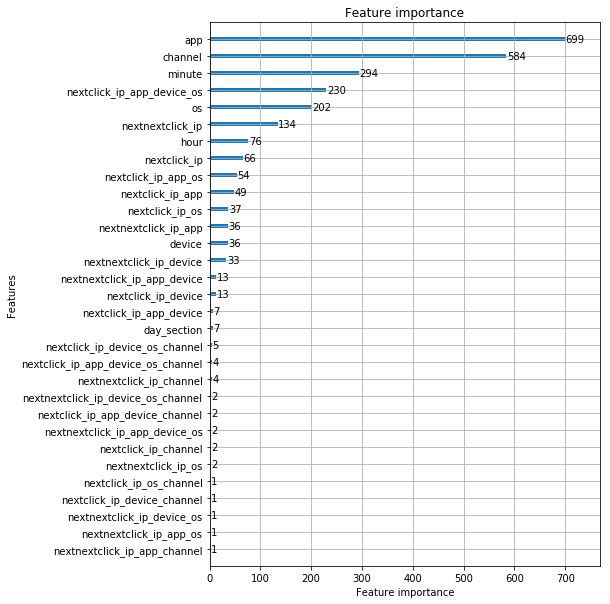

In [55]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

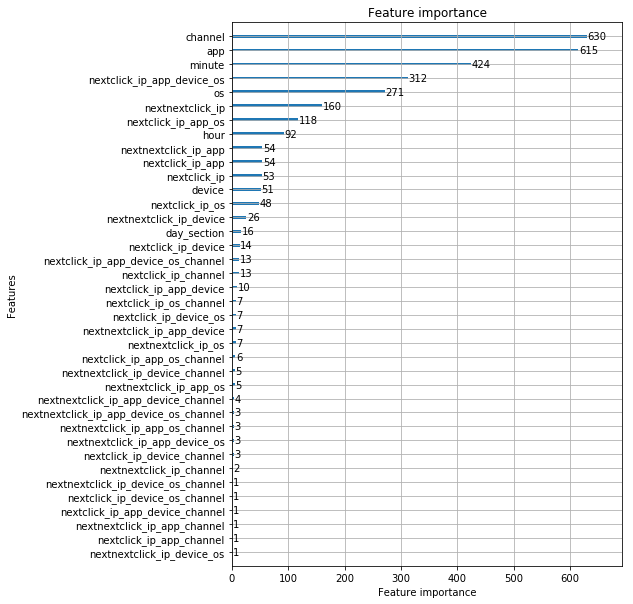

In [64]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [56]:
import pickle

In [57]:
with open('../results/{}.pickle'.format(to_get), 'wb') as f:
    pickle.dump(lgb_model, f)

# Create submission

In [58]:
test = pd.read_hdf(hdf_path, key='test')

In [59]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [60]:
test_all_comb_feats =[(test, comb_feat) for comb_feat in all_comb_feats]

In [61]:
test_all_comb_feats = [comb for comb in test_all_comb_feats if 'ip' in comb[1]]

In [62]:
test = process(test, test_all_comb_feats, to_get)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting next click...
2018-04-23 18:50:15.907322


  0%|          | 0/16 [00:00<?, ?it/s]

Concat...


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


In [63]:
test.head()

,click_id,ip,app,device,os,channel,click_time,hour,minute,in_test_hh,...,nextclick_ip_app_device_os,nextnextclick_ip_app_device_os,nextclick_ip_app_device_channel,nextnextclick_ip_app_device_channel,nextclick_ip_app_os_channel,nextnextclick_ip_app_os_channel,nextclick_ip_device_os_channel,nextnextclick_ip_device_os_channel,nextclick_ip_app_device_os_channel,nextnextclick_ip_app_device_os_channel
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,240,1,...,-1,-1,1434,4560,-1,-1,-1,-1,-1,-1
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,240,1,...,399,750,359,580,18377,-1,18377,-1,18377,-1
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,240,1,...,88,215,88,215,88,215,88,215,88,215
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,240,1,...,425,488,3181,-1,3181,-1,3181,-1,3181,-1
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,240,1,...,1208,2750,1208,-1,1208,-1,1208,-1,1208,-1


In [64]:
pred = lgb_model.predict(test.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [65]:
test.loc[:, 'is_attributed'] = pred

In [68]:
test.loc[:, ['click_id', 'is_attributed']].to_csv('../results/{}.csv'.format('_'.join(to_get)), float_format='%.9f', index=False)

In [ ]:
test.loc[:, ['click_id', 'is_attributed']].head()